# **Analyzing Trends in Paying Users on Educational Platform**

**Key Initial Information:**

1. **Definition of "Paying Users":** How does the platform define "paying users"? Does it include all users who make a transaction, or are there specific criteria?  
2. **Analysis Period:** Is there a specific time range for this analysis?  
3. **Platform Data - "Transaction Data" and "Registration Data":** What is the format of these datasets? What columns are available? Does the data include user demographics?  

**Work Plan:**

1. **Understand Data Structure:** Identify relevant columns in both datasets.  
2. **Write SQL Queries:**  
   * Calculate the `number of new paying users` and `cumulative number of paying users` per month.  
   * Calculate the `number of new recurring paying users` and `cumulative number of recurring paying users` per month.  
3. **Visualize Trends:** Use a line chart to illustrate the trends of `paying users` and `recurring paying users` over time.  
4. **Further Analysis:** If possible, segment users (e.g., by demographics, product types purchased) to gain deeper insights.

In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load dataset
platform_registration = pd.read_csv("/kaggle/input/datanya/platform_registrationdata.csv")
platform_transaction = pd.read_csv("/kaggle/input/datanya/platform_transaction data.csv")

#Define lambda to run query
sql = lambda q:sqldf(q, globals())

#Overview data
print("\nRegistration Data:")
print(platform_registration.head(3))

print("\nTransaction Data:")
print(platform_transaction.head(3))


Registration Data:
   id       name registered_at    platform
0   1  Demarquez    2019-04-17  Sekolah.ku
1   2  Jhoseline    2021-05-15   Karier.ku
2   3    Jisaiah    2021-08-17  Sekolah.ku

Transaction Data:
   id  user_id   status  amount        date
0   1     6314  success   37810  2022-02-06
1   2      723  success   73840  2022-05-25
2   3     8655  success  130889  2020-11-05


In [2]:
# Dataset Information
print("\nRegistration Dataset Information:")
print(platform_registration.info())

print("\nTransaction Dataset Information:")
print(platform_transaction.info())


Registration Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             10000 non-null  int64 
 1   name           10000 non-null  object
 2   registered_at  10000 non-null  object
 3   platform       10000 non-null  object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB
None

Transaction Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30448 entries, 0 to 30447
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       30448 non-null  int64 
 1   user_id  30448 non-null  int64 
 2   status   30448 non-null  object
 3   amount   30448 non-null  int64 
 4   date     30448 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.2+ MB
None


### **Data Exploration Results**  

#### **1. Dataset: Platform Transaction Data** (`platform_transaction_data.csv`)  
- **Rows x Columns**: 30,448 x 5  
- **Columns**:  
  - `id` (int64) → Unique transaction ID.  
  - `user_id` (int64) → User ID.  
  - `status` (object) → Transaction status (needs validation for unique values: success/failure).  
  - `amount` (int64) → Transaction amount.  
  - `date` (object) → Transaction date (needs conversion to `datetime` format).  
- **Missing Values**: **0** → Complete dataset with no missing values.  
- **Notes**: The `date` column needs to be converted to a proper datetime format for monthly analysis.  

#### **2. Dataset: Platform Registration Data** (`platform_registration_data.csv`)  
- **Rows x Columns**: 10,000 x 4  
- **Columns**:  
  - `id` (int64) → Unique user ID.  
  - `name` (object) → User name.  
  - `registered_at` (object) → Registration date (needs conversion to `datetime`).  
  - `platform` (object) → Registration platform (needs analysis for unique values).  
- **Missing Values**: **0** → Complete dataset with no missing values.  
- **Notes**: The `registered_at` column needs to be converted to datetime format to align with analysis needs.  

In [3]:
# Monthly Paying Users Analysis
query2 = """
WITH
-- Get the first transaction date for each user
First_Payment AS (
    SELECT
        user_id,
        MIN(date) AS first_payment_date
    FROM platform_transaction
    WHERE status = 'success'
    GROUP BY user_id
),
-- Identify users who have made more than one payment
Recurring_Users AS (
    SELECT
        user_id,
        COUNT(*) AS payment_count,
        MIN(date) AS first_payment_date
    FROM platform_transaction
    WHERE status = 'success'
    GROUP BY user_id
    HAVING payment_count > 1
),
-- Get the second transaction date for each user
Second_Payment AS (
    SELECT
        t1.user_id,
        MIN(t1.date) AS second_payment_date
    FROM platform_transaction t1
    JOIN Recurring_Users t2
    ON t1.user_id = t2.user_id
    WHERE t1.date > t2.first_payment_date
    GROUP BY t1.user_id
),
-- Prepare monthly metrics for new and recurring paying users
Metrics AS (
    SELECT
        strftime('%Y-%m', COALESCE(f.first_payment_date, s.second_payment_date)) AS payment_month,
        COUNT(DISTINCT f.user_id) AS new_paying_users,
        COUNT(DISTINCT s.user_id) AS new_recurring_paying_users
    FROM platform_transaction t
    LEFT JOIN First_Payment f ON t.user_id = f.user_id
    LEFT JOIN Second_Payment s ON t.user_id = s.user_id
    WHERE status = 'success'
    GROUP BY payment_month
)
-- Add cumulative metrics for each category
SELECT
    payment_month,
    new_paying_users,
    SUM(new_paying_users) OVER (ORDER BY payment_month) AS cumulative_paying_users,
    new_recurring_paying_users,
    SUM(new_recurring_paying_users) OVER (ORDER BY payment_month) AS cumulative_recurring_paying_users
FROM Metrics
ORDER BY payment_month;
"""

# Run the query
monthly_metrics = sql(query2)
print("Monthly Metrics")
# Display the table
print(monthly_metrics)

# Save to CSV (optional)
# monthly_metrics.to_csv('monthly_metrics.csv', index=False)

Monthly Metrics
   payment_month  new_paying_users  cumulative_paying_users  \
0        2018-04                 5                        5   
1        2018-05                20                       25   
2        2018-06                19                       44   
3        2018-07                37                       81   
4        2018-08                40                      121   
5        2018-09                63                      184   
6        2018-10                61                      245   
7        2018-11                70                      315   
8        2018-12                71                      386   
9        2019-01                61                      447   
10       2019-02                56                      503   
11       2019-03                80                      583   
12       2019-04                58                      641   
13       2019-05               105                      746   
14       2019-06                55     

In [4]:
monthly_metrics.describe()

,new_paying_users,cumulative_paying_users,new_recurring_paying_users,cumulative_recurring_paying_users
count,50.000000,50.00000,50.000000,50.000000
mean,81.620000,1847.46000,70.320000,1774.700000
std,26.602048,1287.52102,29.202628,1190.797045
min,5.000000,5.00000,5.000000,5.000000
25%,65.250000,667.25000,55.000000,667.250000
50%,87.500000,1766.00000,74.000000,1755.000000
75%,101.000000,2965.50000,93.500000,2892.250000
max,137.000000,4081.00000,135.000000,3516.000000


In [5]:
# Calculate Growth Rate
monthly_metrics['new_paying_users_growth_rate'] = monthly_metrics['new_paying_users'].pct_change() * 100
monthly_metrics['new_recurring_paying_users_growth_rate'] = monthly_metrics['new_recurring_paying_users'].pct_change() * 100

# Average Growth Rate
average_new_paying_users_growth = monthly_metrics['new_paying_users_growth_rate'].mean()
average_new_recurring_paying_users_growth = monthly_metrics['new_recurring_paying_users_growth_rate'].mean()

print("Average New Paying Users Growth Rate:", average_new_paying_users_growth)
print("Average New Recurring Paying Users Growth Rate:", average_new_recurring_paying_users_growth)

Average New Paying Users Growth Rate: 14.357023541746733
Average New Recurring Paying Users Growth Rate: 10.023904996745186


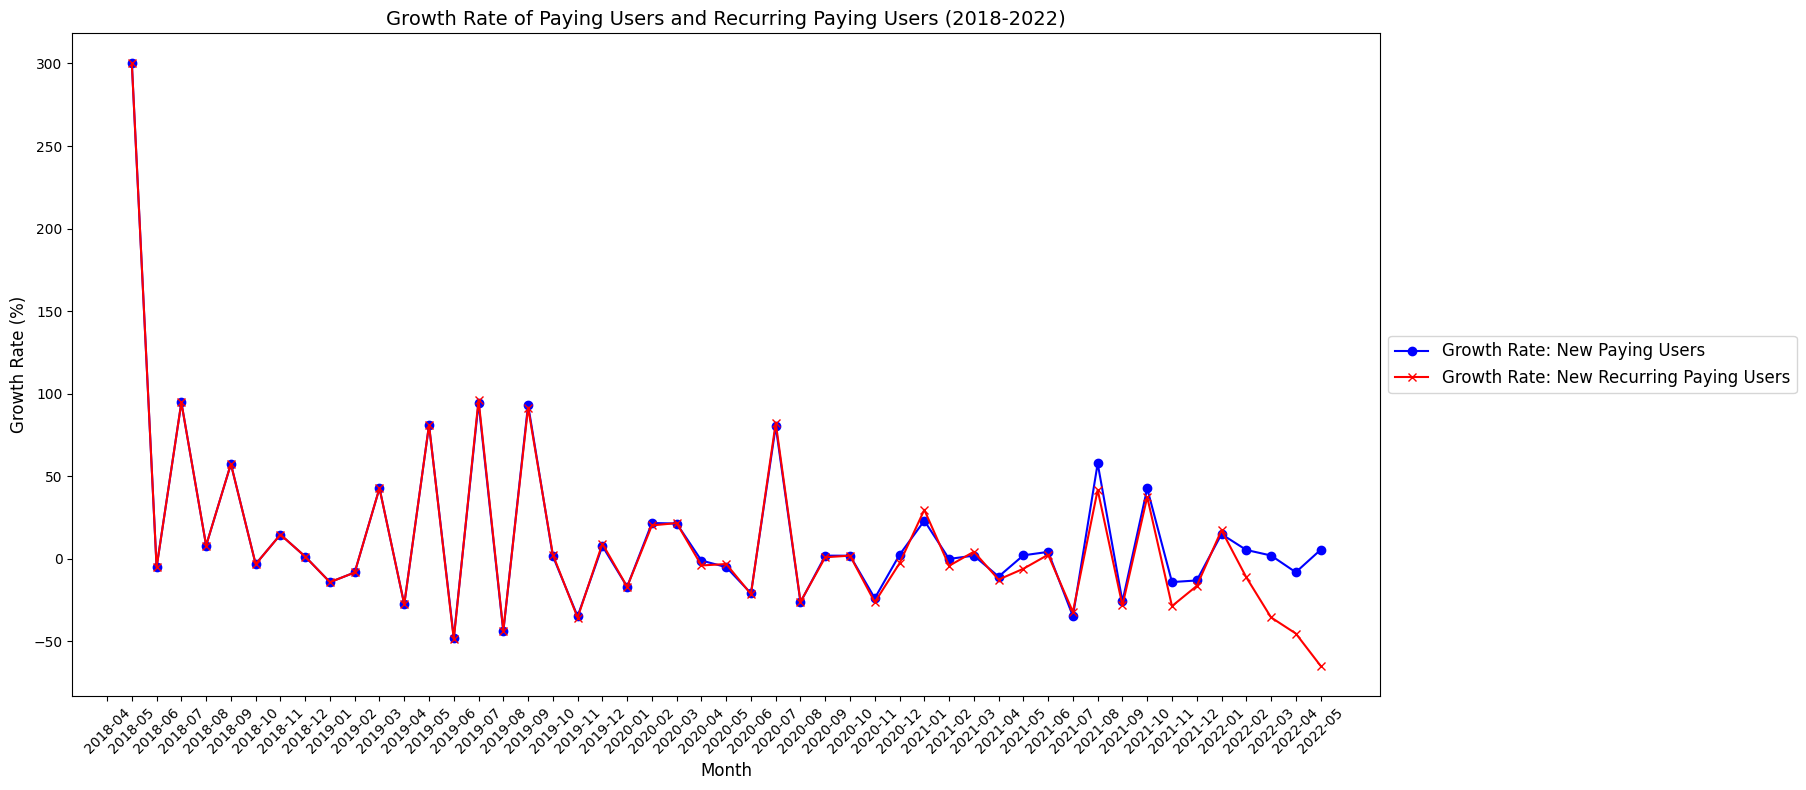

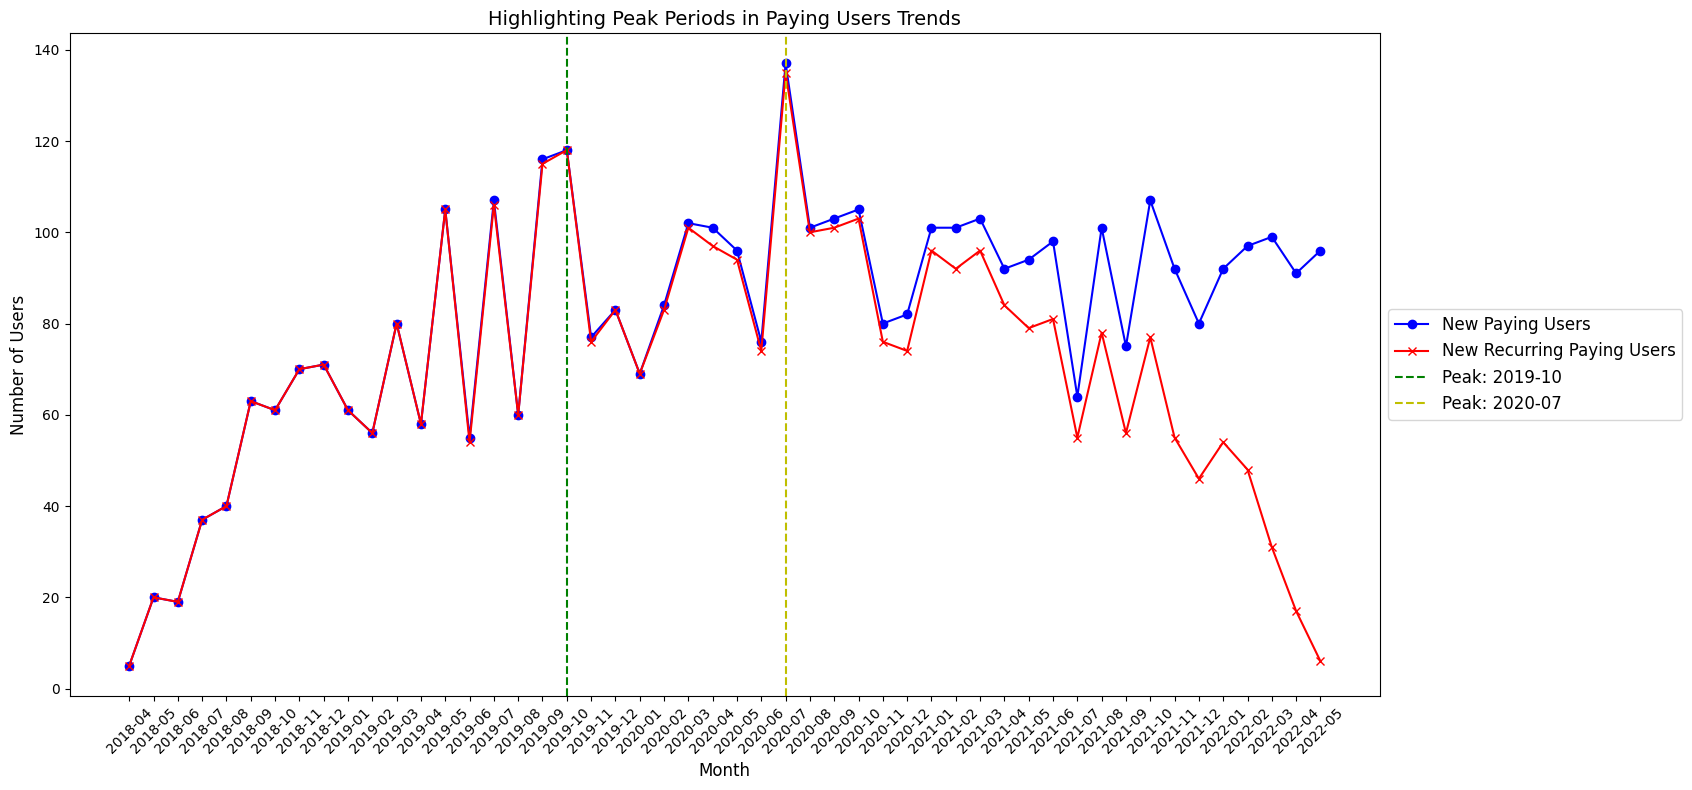

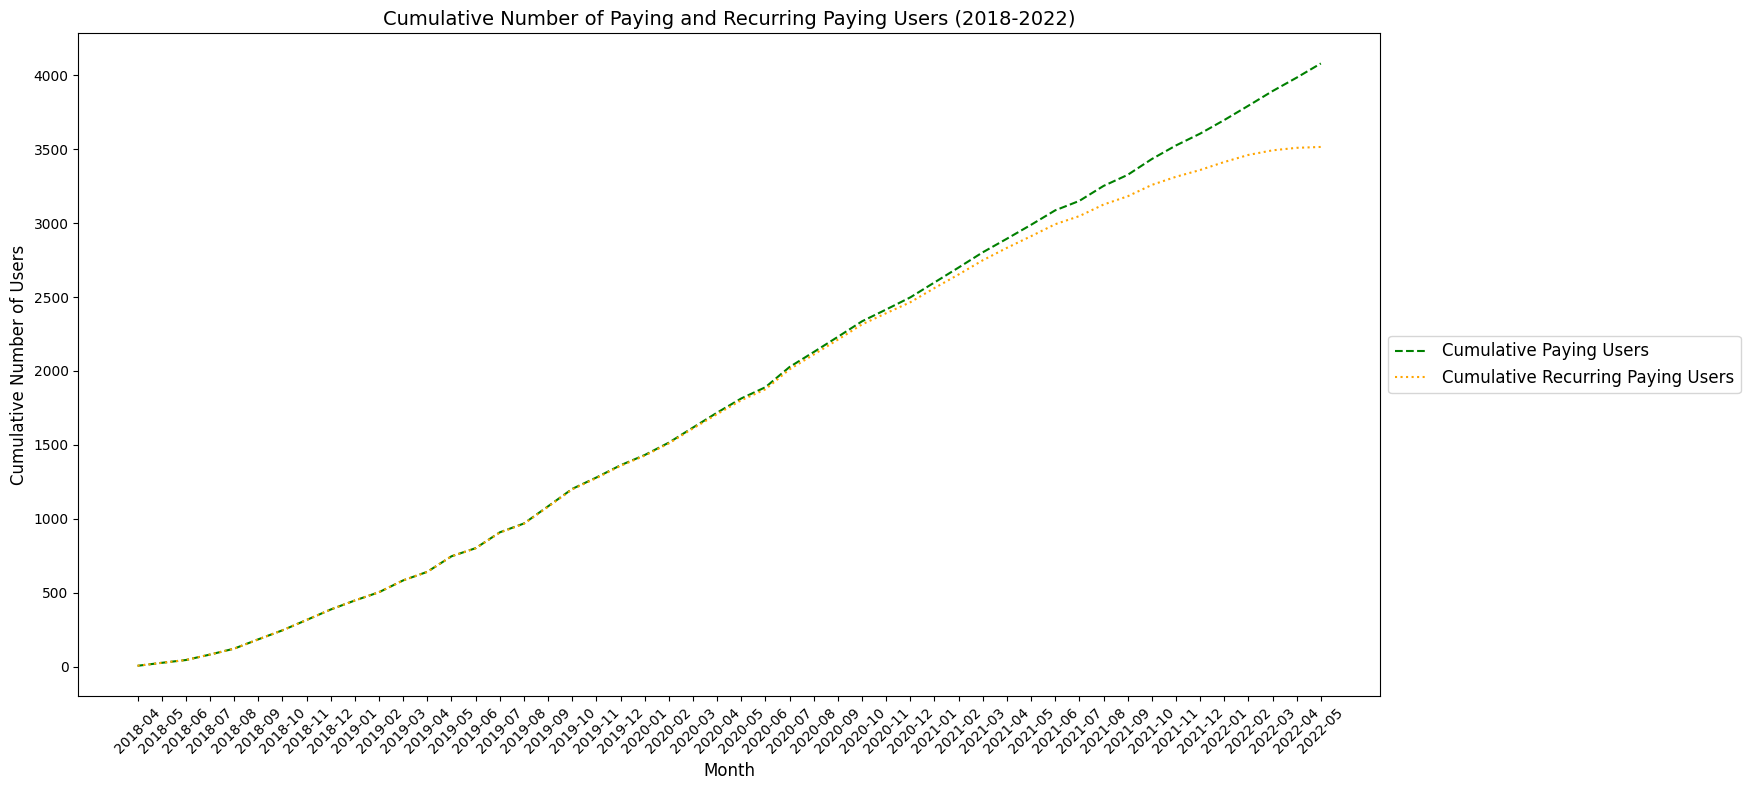

In [6]:
import matplotlib.pyplot as plt

# Calculate growth rates for new paying users and new recurring paying users
monthly_metrics['new_paying_users_growth_rate'] = monthly_metrics['new_paying_users'].pct_change() * 100
monthly_metrics['new_recurring_paying_users_growth_rate'] = monthly_metrics['new_recurring_paying_users'].pct_change() * 100

# 1. Growth Rate Visualization
plt.figure(figsize=(14, 8))

# Plotting growth rates for new paying users and new recurring paying users
plt.plot(monthly_metrics['payment_month'], monthly_metrics['new_paying_users_growth_rate'], label='Growth Rate: New Paying Users', color='b', marker='o')
plt.plot(monthly_metrics['payment_month'], monthly_metrics['new_recurring_paying_users_growth_rate'], label='Growth Rate: New Recurring Paying Users', color='r', marker='x')

# Adding labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.title('Growth Rate of Paying Users and Recurring Paying Users (2018-2022)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Adding a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Save the figure
plt.savefig('growth_rate_visualization.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# 2. Peak Periods Visualization
plt.figure(figsize=(14, 8))

# Highlighting the peaks with vertical lines
plt.plot(monthly_metrics['payment_month'], monthly_metrics['new_paying_users'], label='New Paying Users', color='b', marker='o')
plt.plot(monthly_metrics['payment_month'], monthly_metrics['new_recurring_paying_users'], label='New Recurring Paying Users', color='r', marker='x')

# Highlighting peaks at specific months (e.g., 2019-10 and 2020-07)
plt.axvline(x='2019-10', color='g', linestyle='--', label='Peak: 2019-10')
plt.axvline(x='2020-07', color='y', linestyle='--', label='Peak: 2020-07')

# Adding labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('Highlighting Peak Periods in Paying Users Trends', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Adding a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Save the figure
plt.savefig('peak_periods_visualization.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# 3. Cumulative Users Visualization
plt.figure(figsize=(14, 8))

# Plotting cumulative paying users and recurring paying users
plt.plot(monthly_metrics['payment_month'], monthly_metrics['cumulative_paying_users'], label='Cumulative Paying Users', color='g', linestyle='--')
plt.plot(monthly_metrics['payment_month'], monthly_metrics['cumulative_recurring_paying_users'], label='Cumulative Recurring Paying Users', color='orange', linestyle=':')

# Adding labels and title
plt.xlabel('Month', fontsize=12)
plt.ylabel('Cumulative Number of Users', fontsize=12)
plt.title('Cumulative Number of Paying and Recurring Paying Users (2018-2022)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Adding a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Save the figure
plt.savefig('cumulative_users_visualization.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## **Key Findings**
- **New Paying Users** peaked in **2019-10** (118 users) and **2020-07** (137 users), followed by a gradual decline in 2022.
- **Cumulative Paying Users** steadily increased, reaching **4,081 users** by **2022-05**, despite a slowdown in growth post-2020.
- **New Recurring Paying Users** followed a similar pattern, with sharp declines after **2021**.
- **Cumulative Recurring Paying Users** reached **3,516 users** but experienced slowed growth since mid-2021.
- **Significant Peaks** in **2019-10** and **2020-07** suggest external factors like promotions or events driving higher user acquisition.
- **Declining Activity in 2022** signals the need for strategic adjustments to sustain growth.

## **Recommendations**
### **Enhancing User Acquisition Strategies**
- **Analyze Peak Periods:** Investigate successful promotional campaigns in **2019-10** and **2020-07** to replicate effective tactics.
- **Leverage Targeted Marketing:** Implement campaigns focused on periods of historical growth, utilizing personalized promotions, discounts, or limited-time offers.
- **Optimize Referral Programs:** Encourage user referrals by offering incentives for both new and existing users.

### **Boosting Recurring User Engagement**
- **Enhance User Experience:** Improve product usability, onboarding processes, and personalized recommendations to increase long-term retention.
- **Introduce Loyalty Programs:** Reward recurring paying users with exclusive benefits to maintain engagement.
- **Re-engagement Strategies:** Use automated follow-ups, reminders, and personalized incentives to bring back users who show signs of churn.

### **Addressing 2022 Slowdown**
- **Market Expansion:** Explore new demographic or regional markets to widen user reach.
- **Product Innovation:** Identify potential feature updates or new offerings to rekindle user interest.
- **Seasonal and Event-Based Promotions:** Plan strategic promotions tied to seasonal trends or industry events to attract users during slow periods.

### **Continuous Data-Driven Monitoring**
- **Real-Time Analytics:** Regularly monitor user trends to identify shifts in behavior and adapt strategies accordingly.
- **A/B Testing Campaigns:** Experiment with different marketing and engagement approaches to determine the most effective tactics.
- **Feedback Collection:** Actively gather user feedback to refine services and improve customer satisfaction.

## **Conclusion**
The analysis suggests that while user acquisition and retention have been strong historically, the slowdown in 2022 indicates the need for proactive strategies. Implementing data-driven acquisition techniques, enhancing recurring user engagement, and continuously optimizing based on insights will help sustain long-term growth.

## **Dashboard Shiny: Paying Users Dashboard**
For a more interactive analysis of these metrics, visit the **Shiny Dashboard**:  
🔗 [**Paying Users Dashboard**](https://adamdandi.shinyapps.io/Paying_Users_Dashboard/)